## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

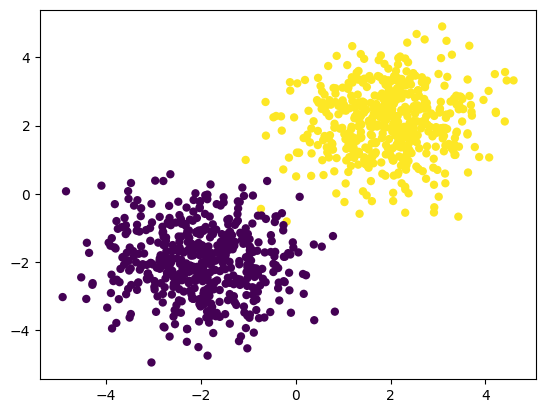

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())
# print(net)

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [4]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

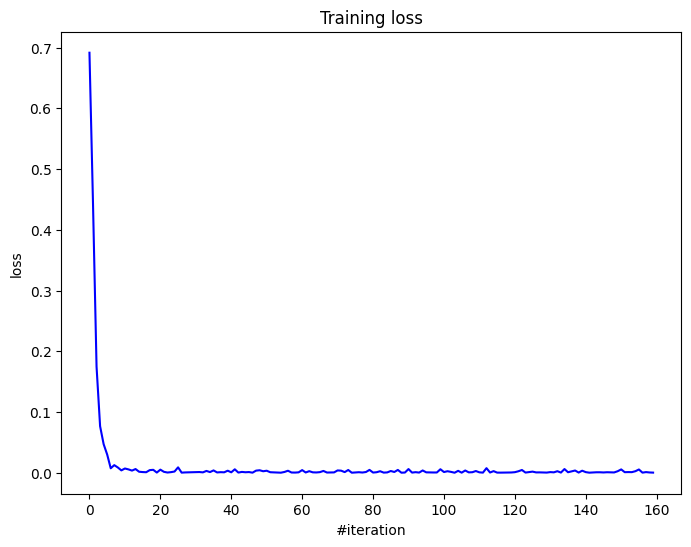

Current loss: 0.000211


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [5]:
import mnist

X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [6]:
X_train = X_train.reshape((X_train.shape[0], 28 * 28))
X_val = X_val.reshape((X_val.shape[0], 28 * 28))
X_test = X_test.reshape((X_test.shape[0], 28 * 28))

One-hot encode the labels first.

In [7]:
from sklearn.preprocessing import OneHotEncoder
import numpy.typing as npt
ohe = OneHotEncoder(sparse=False)
y_train = ohe.fit_transform(y_train.reshape(-1, 1))
y_val = ohe.fit_transform(y_val.reshape(-1, 1))
y_test = ohe.fit_transform(y_test.reshape(-1, 1))

In [8]:
y_train.shape

(50000, 10)

In [9]:
ohe.inverse_transform(y_train).ravel().shape

(50000,)

In [10]:
n_classes = y_train.shape[1]
NUMBER_OF_FEATURES = X_train.shape[1]

In [11]:
from collections.abc import Callable, Iterable

In [123]:
def get_batches(X: npt.ArrayLike, 
                y: npt.ArrayLike,
                train: bool=False, 
                batch_size: int=128):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    if train:
        np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], y[batch_idx]

def model_constructor(activation: Callable = ReLU,
                      final_activation: Callable = LogSoftMax,
                      batch: bool=False):
    net = Sequential()
    net.add(Linear(NUMBER_OF_FEATURES, 128))
    net.add(activation())
    net.add(Linear(128, 64))
    if batch:
        net.add(BatchNormalization(alpha=0.8))
        net.add(ChannelwiseScaling(64))
    net.add(activation())
    net.add(Linear(64, n_classes))
    net.add(final_activation())

    return net

In [122]:
def plot_epoch(history: list):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
    train_loss, train_acc, val_loss, val_acc = zip(*history)
    ax[0].plot(train_loss, label='train_loss', color="red")
    ax[0].plot(val_loss, label='val_loss', color="blue")
    ax[1].plot(train_acc, label='train_acc', color="green")
    ax[1].plot(val_acc, label='val_acc', color="lime")
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')

    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("loss")
 
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("accuracy")

    plt.show()

In [120]:
def fit_epoch(model, tepoch, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tepoch:
        model.zeroGradParameters()
        outputs = model.forward(inputs)
        loss = criterion.forward(outputs, labels)
        dp = criterion.backward(outputs, labels)
        model.backward(inputs, dp)
        optimizer(
            model.getParameters(),
            model.getGradParameters(),
            optimizer_config,
            optimizer_state
        )
        preds = np.argmax(outputs, 1)
        running_loss += loss * inputs.shape[0]
        running_corrects += np.sum(preds == ohe.inverse_transform(labels).ravel())
        processed_data += inputs.shape[0]
        tepoch.set_postfix(loss=loss,
                accuracy=str(100. * running_corrects / processed_data)[:4])
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        model.zeroGradParameters()

        outputs = model.forward(inputs)
        loss = criterion.forward(outputs, labels)
        preds = np.argmax(outputs, 1)

        running_loss += loss * inputs.shape[0]
        running_corrects += np.sum(preds == ohe.inverse_transform(labels).ravel())
        processed_size += inputs.shape[0]
    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size
    return val_loss, val_acc

In [121]:
from tqdm import tqdm
import time
def train_model(model: Module, X_train: Iterable, 
                y_train: Iterable, X_val: Iterable,
                y_val: Iterable, optimizer: Callable,
                criterion: Criterion, batch_size:int = 128,
                show: bool=True, n_epochs: int=20, log_time: bool=True
                ):
                
    history = []
    times = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    start_time = time.time() if log_time else None
    for epoch in range(n_epochs):
        batches = get_batches(X_train, y_train, train=True, batch_size=batch_size)

        # train step
        model.train()
        train_losses = []
        val_losses = []
        with tqdm(batches, unit="batch", total=len(X_train) // batch_size) as tepoch:
            tepoch.set_description("Epoch {} / {}".format(epoch + 1, n_epochs))
            train_loss, train_acc = fit_epoch(model, tepoch, criterion, optimizer)

        # validation step
        val_batches = get_batches(X_val, y_val, batch_size)
        model.evaluate()
        val_loss, val_acc = eval_epoch(model, val_batches, criterion)
        history.append((train_loss, train_acc, val_loss, val_acc))
        if start_time:
            times.append(time.time() - start_time)
        if show:
            display.clear_output(wait=True)
            plot_epoch(history)
        tepoch.update(1)
        tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                        v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    if log_time:
        return history, times
    return history

In [19]:
criterion = ClassNLLCriterion()
n_epochs = 10
batch_size = 256
optimizer = adam_optimizer
optimizer_config = {'learning_rate': 3e-4, 'beta1': 0.5, 'beta2': 0.5, 'epsilon': 1e-5}
optimizer_state = {}

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.

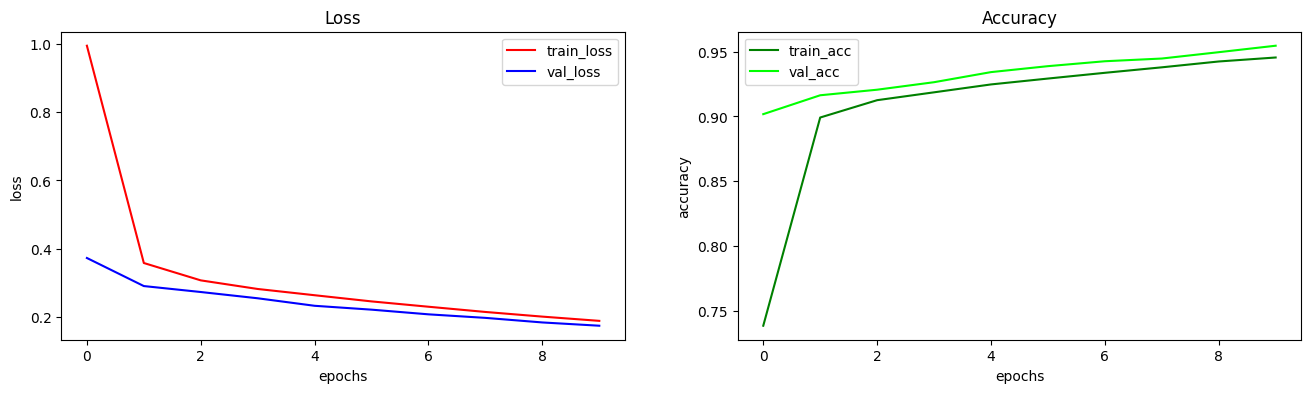


Epoch 010 train_loss: 0.1885     val_loss 0.1743 train_acc 0.9456 val_acc 0.9547


In [28]:
activations = [ReLU, ELU, LeakyReLU, SoftPlus]
histories = {}

for activation in activations:
    model = model_constructor(activation=activation)
    print(model)
    histories[activation.__name__ + " without batchnorm"] = {}
    histories[activation.__name__ + " without batchnorm"]["history"], histories[activation.__name__ + " without batchnorm"]["times"] = \
        train_model(model, X_train, y_train, X_val, y_val, optimizer, criterion=criterion, n_epochs=n_epochs)

In [29]:
def addlabels(y):
    for i in range(len(y)):
        plt.text(i, y[i], round(y[i], 2), ha = 'center')

In [36]:
def plot_activation_results(histories: dict, title: str=None):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
    times = {}
    for (key, value) in histories.items():
        train_loss, train_acc, val_loss, val_acc = zip(*value['history'])
        times[key] = sum(value['times'])
        ax[0, 0].plot(train_loss, label=key + ' train_loss')
        ax[0, 1].plot(val_loss, label=key + ' val_loss')
        ax[1, 0].plot(train_acc, label=key + ' train_acc')
        ax[1, 1].plot(val_acc, label=key + ' val_acc')
        ax[0, 0].set_title('Train Loss')
        ax[1, 0].set_title('Train Accuracy')

        ax[0, 1].set_title('Validation Loss')
        ax[1, 1].set_title('Validation Accuracy')

        ax[0, 0].legend(loc='best')
        ax[0, 1].legend(loc='best')
        ax[1, 0].legend(loc='best')
        ax[1, 1].legend(loc='best')
        
        ax[0, 0].set_xlabel("epochs")
        ax[0, 0].set_ylabel("loss")

        ax[0, 1].set_xlabel("epochs")
        ax[0, 1].set_ylabel("loss")
    
        ax[1, 0].set_xlabel("epochs")
        ax[1, 0].set_ylabel("accuracy")


        ax[1, 1].set_xlabel("epochs")
        ax[1, 1].set_ylabel("accuracy")
    
    if title:
        plt.suptitle(title)
        
    plt.show()

    plt.figure(figsize=(20,4))
    plt.bar(x=times.keys(), height=times.values())
    addlabels(list(times.values()))
    plt.show()

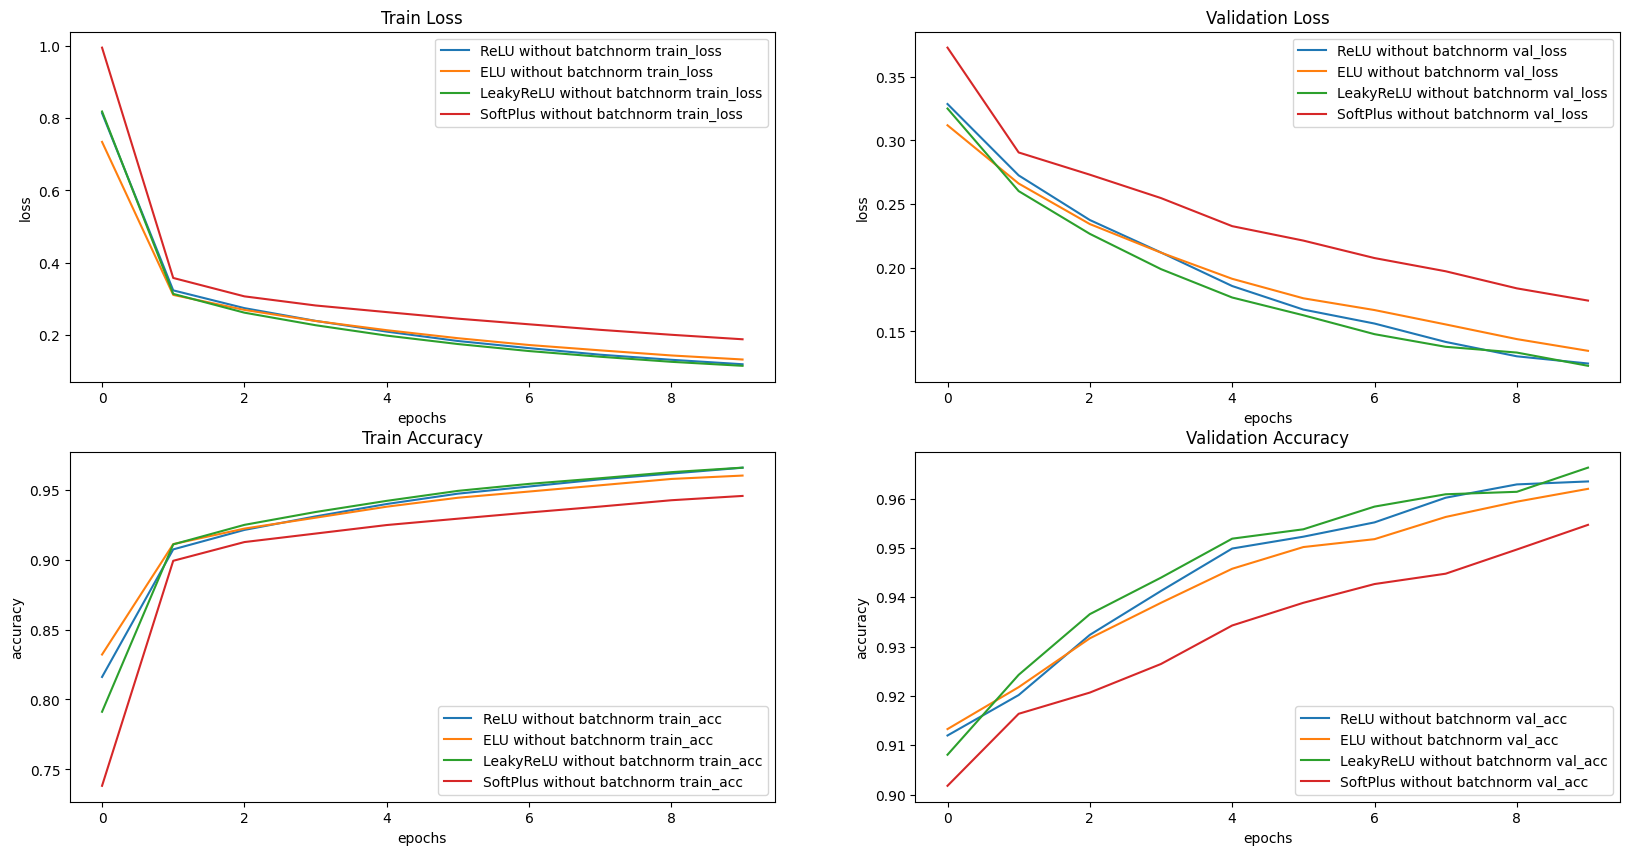

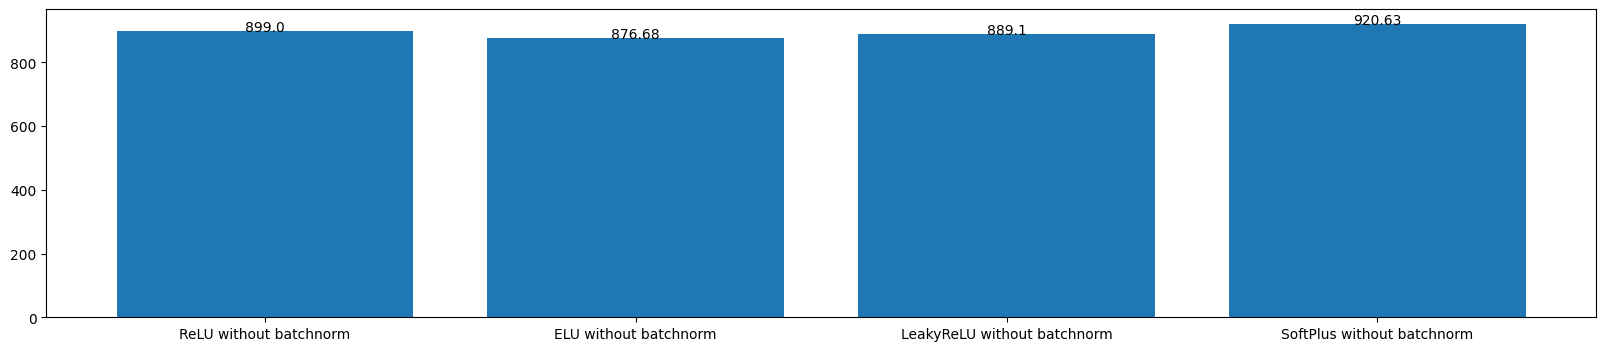

In [37]:
plot_activation_results(histories)

## <font color="green"> Inferences </font>

* As we can see, `ReLU` and `Leaky_ReLU`, as piecewise linear, are calculated the fastest. The model on `ELU` and `SoftMax` is considered longer, where the exponent and logarithm are calculated.

* `ReLU` performed slightly better and SoftPlus worse in comparison with others activation functions.

- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.

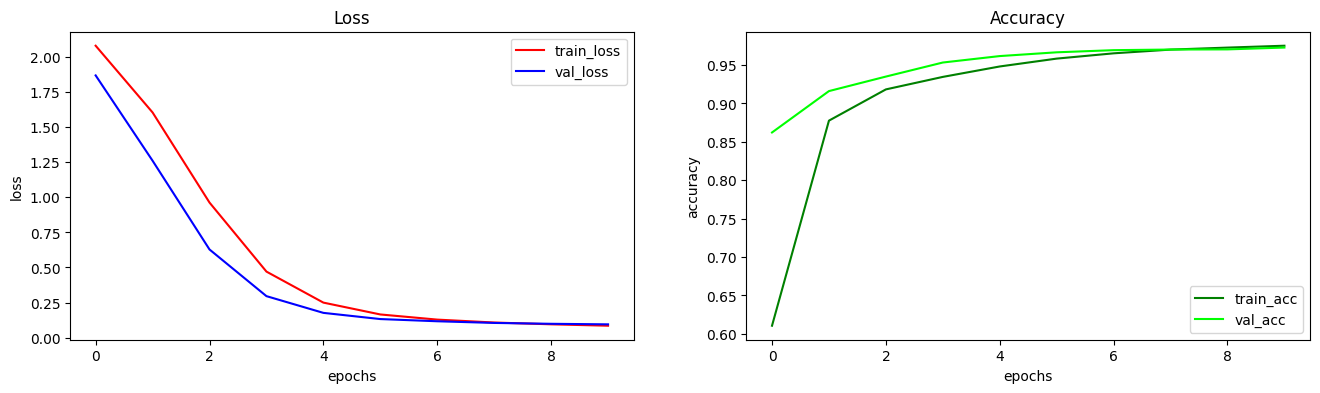


Epoch 010 train_loss: 0.0844     val_loss 0.0942 train_acc 0.9752 val_acc 0.9728


In [34]:
criterion = ClassNLLCriterion()
n_epochs = 10
batch_size = 256
optimizer = adam_optimizer
optimizer_config = {'learning_rate': 3e-4, 'beta1': 0.5, 'beta2': 0.5, 'epsilon': 1e-5}
optimizer_state = {}
histories_wb = {}

for activation in activations:
    model = model_constructor(activation=activation, batch=True)
    print(model)
    histories_wb[activation.__name__ + " with batchnorm"] = {}
    histories_wb[activation.__name__ + " with batchnorm"]["history"], histories_wb[activation.__name__ + " with batchnorm"]["times"] = \
        train_model(model, X_train, y_train, X_val, y_val, optimizer, criterion=criterion, n_epochs=n_epochs)

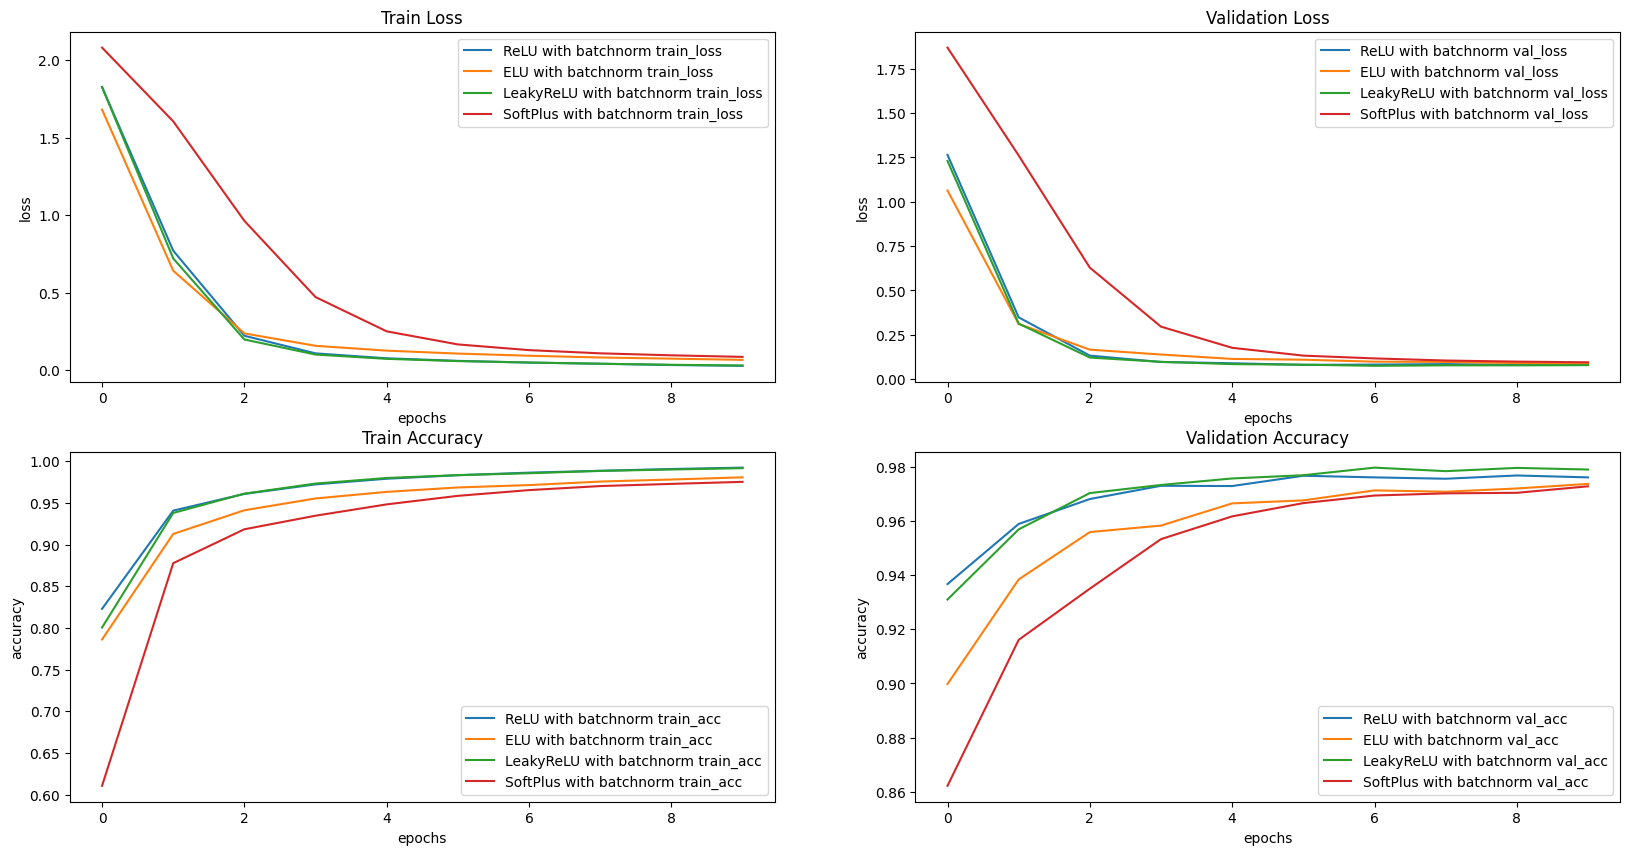

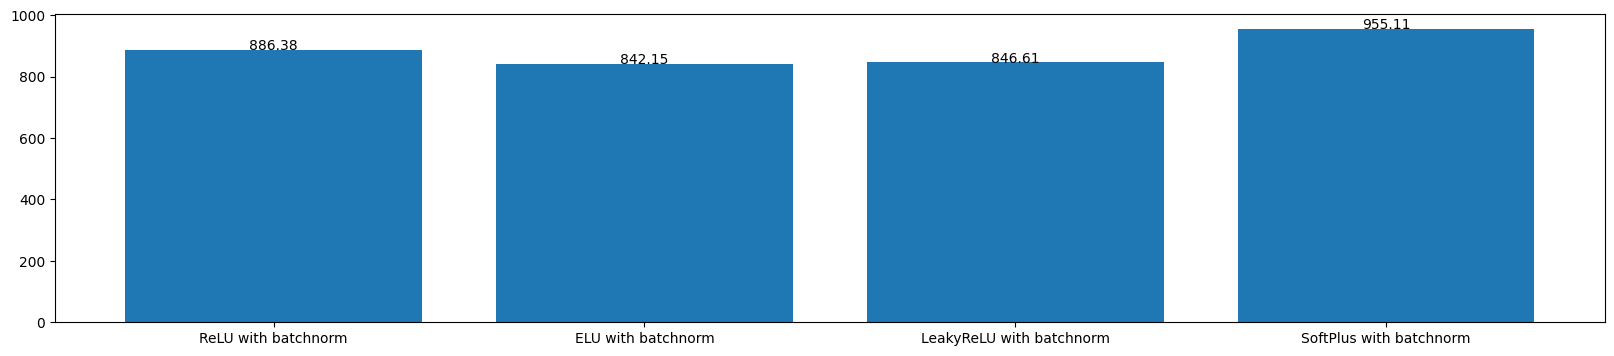

In [38]:
plot_activation_results(histories_wb)

In [39]:
all_history = histories | histories_wb

In [47]:
all_history.keys()

dict_keys(['ReLU without batchnorm', 'ELU without batchnorm', 'LeakyReLU without batchnorm', 'SoftPlus without batchnorm', 'ReLU with batchnorm', 'ELU with batchnorm', 'LeakyReLU with batchnorm', 'SoftPlus with batchnorm'])

In [53]:
relu_comparison = {}
elu_comparison = {}
leakyrelu_comparison = {}
softplus_comparison = {}

for (key, value) in all_history.items():
    if "ReLU" in key[:4]:
        relu_comparison[key] = all_history[key]["history"]
    elif "ELU" in key[:3]:
        elu_comparison[key] = all_history[key]["history"]
    elif "Leak" in key[:4]:
        leakyrelu_comparison[key] = all_history[key]["history"]
    else: 
        softplus_comparison[key] = all_history[key]["history"]
assert len(relu_comparison) == len(elu_comparison) == len(leakyrelu_comparison) == len(softplus_comparison)

comparisons = {"ReLU comparison" : relu_comparison, 
               "ELU comparison" : elu_comparison,
               "LeakyReLU comparison" : leakyrelu_comparison,
               "Softplus comparison" : softplus_comparison
}

In [59]:
def plot_batch_comparison(histories: list):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
    for (key, value) in histories.items():
        train_loss, train_acc, val_loss, val_acc = zip(*value)
        ax[0].plot(train_loss, label=key + ' train_loss')
        ax[0].plot(val_loss, label=key + ' val_loss')
        ax[1].plot(train_acc, label=key + ' train_acc')
        ax[1].plot(val_acc, label=key + ' val_acc')
        ax[0].set_title('Loss')
        ax[1].set_title('Accuracy')

        ax[0].legend(loc='best')
        ax[1].legend(loc='best')
        
        ax[0].set_xlabel("epochs")
        ax[0].set_ylabel("loss")
    
        ax[1].set_xlabel("epochs")
        ax[1].set_ylabel("accuracy")

    plt.show()

 ## ReLU comparison 

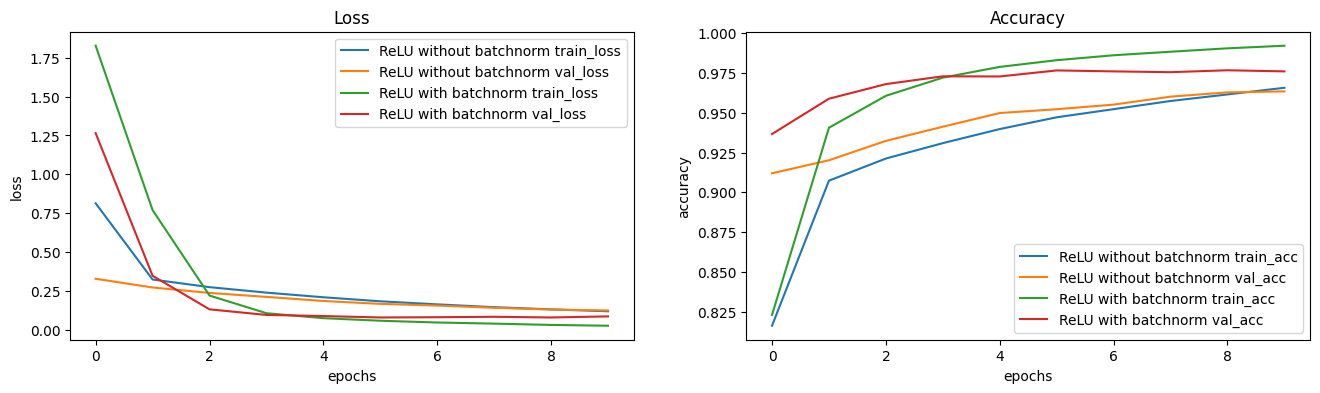

 ## ELU comparison 

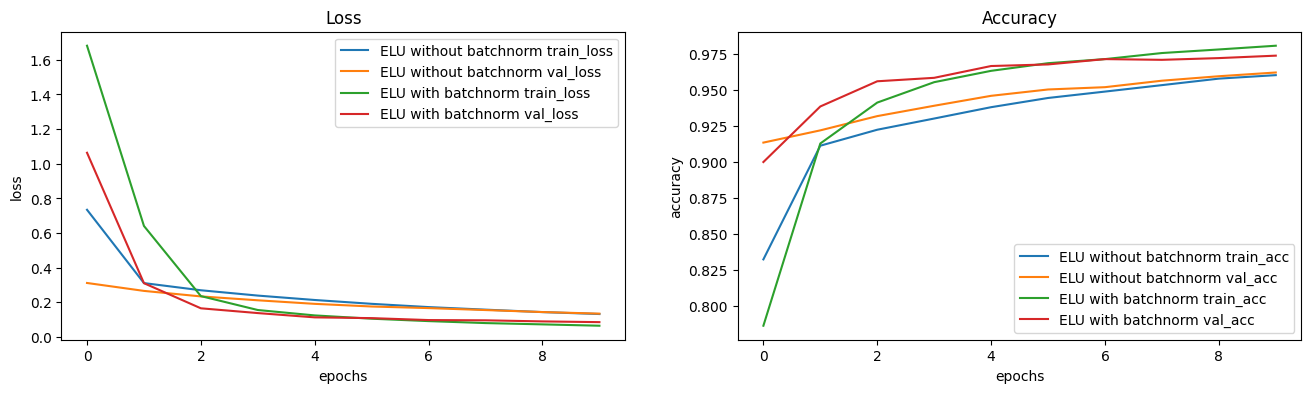

 ## LeakyReLU comparison 

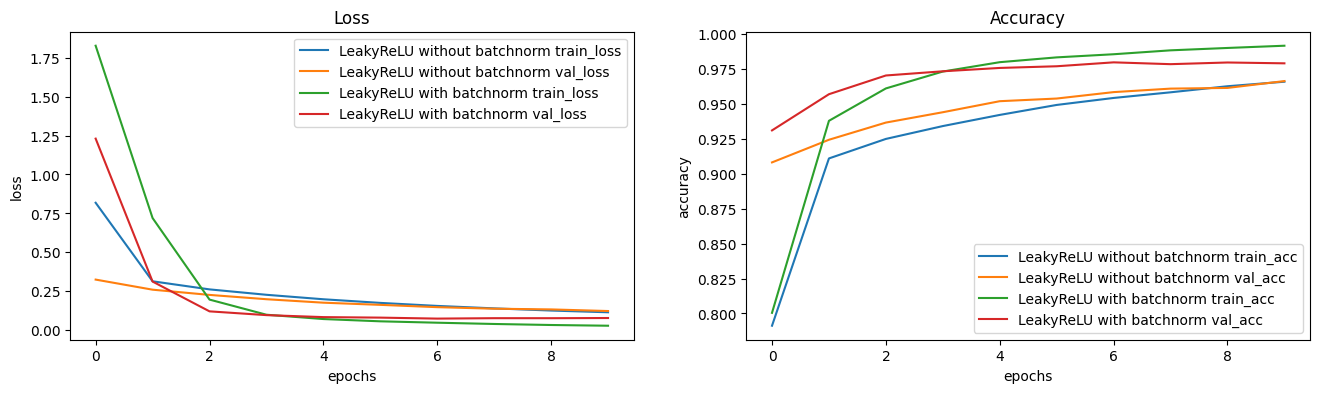

 ## Softplus comparison 

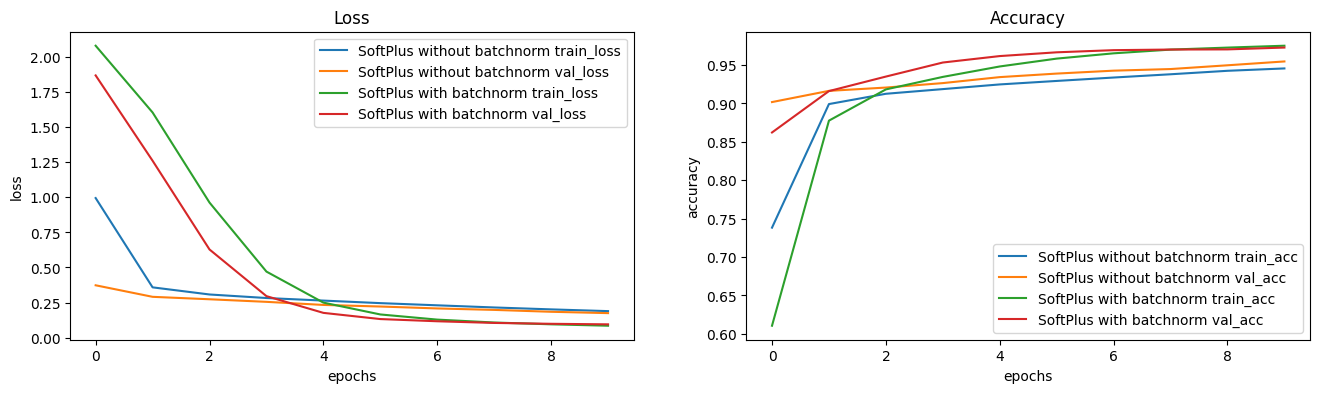

In [67]:
from IPython.display import display as disp, Markdown
for (key, value) in comparisons.items():
    disp(Markdown(f' ## {key} '))
    plot_batch_comparison(value)

- Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.

## <font color="green"> Inferences </font>

* The quality significantly improved by the BatchNormalization. As well as time convergency of learning stage.
* `ReLU` and `Leaky_ReLU` still slightly better than other functions.

In [68]:
batch_size = 256
criterion = ClassNLLCriterion()
optimizer = sgd_momentum
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

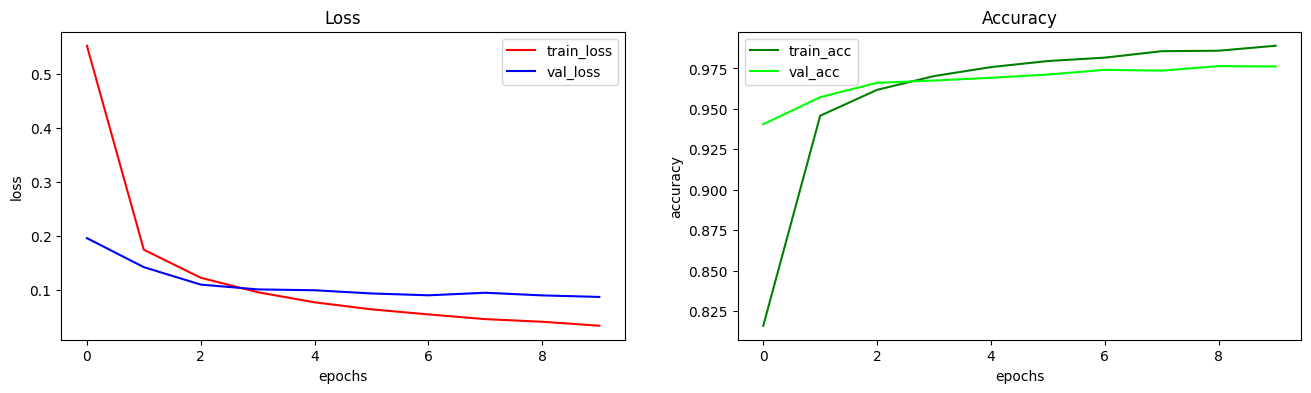


Epoch 010 train_loss: 0.0342     val_loss 0.0874 train_acc 0.9890 val_acc 0.9762


In [69]:
histories_sgd = {}
for activation in activations:
    model = model_constructor(activation=activation)
    print(model)
    histories_sgd[activation.__name__ + " with batchnorm"] = {}
    histories_sgd[activation.__name__ + " with batchnorm"]["history"], histories_sgd[activation.__name__ + " with batchnorm"]["times"] = \
        train_model(model, X_train, y_train, X_val, y_val, optimizer, criterion=criterion, n_epochs=n_epochs)

In [82]:
def plot_loss_optimizer_comparison(histories_adam: list, histories_sgd: list):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
    for i, key in enumerate(histories_adam.keys()):
        train_loss_adam, train_acc, val_loss_adam, val_acc = zip(*histories_adam[key]["history"])
        train_loss_sgd, train_acc, val_loss_sgd, val_acc = zip(*histories_sgd[key]["history"])
        ax[i // 2, i % 2].plot(train_loss_adam, label=key + ' adam_train_loss')
        ax[i // 2, i % 2].plot(train_loss_sgd, label=key + ' sgd_train_loss')
        ax[i // 2, i % 2].plot(val_loss_adam, label=key + ' adam_val_loss')
        ax[i // 2, i % 2].plot(val_loss_sgd, label=key + ' sgd_val_loss')
        ax[i // 2, i % 2].legend(loc="best")

    plt.show()

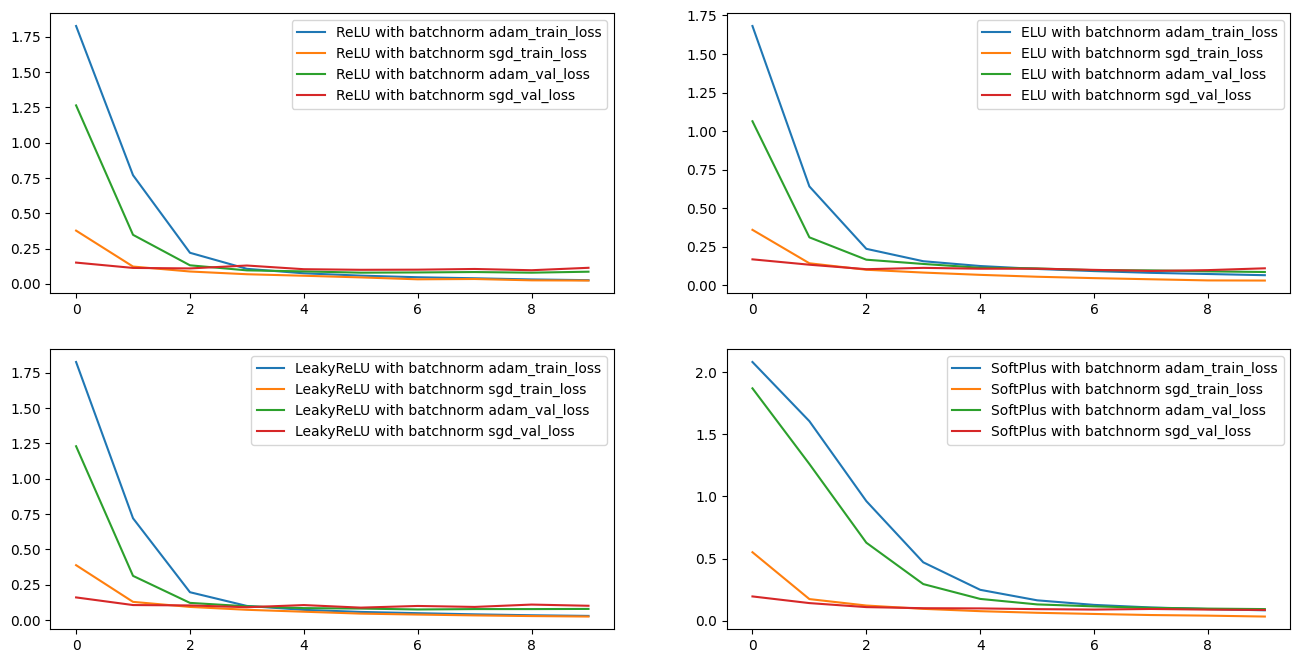

In [83]:
plot_loss_optimizer_comparison(histories_wb, histories_sgd)

- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

As we can see for this architecture with batchnormalization models perform quite simillar except the SoftPlus function. Here is sgd shows meaningfull difference and better perfomance in comparison with adam optimizer. Otherwise adam performs slightly better.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [126]:
model = Sequential()
model.add(Linear(NUMBER_OF_FEATURES, 256))
model.add(BatchNormalization(alpha=0.8))
model.add(ChannelwiseScaling(256))
model.add(LeakyReLU())
model.add(Dropout())
model.add(Linear(256, 128))
model.add(BatchNormalization(alpha=0.8))
model.add(ChannelwiseScaling(128))
model.add(LeakyReLU())
model.add(Dropout(p=0.6))
model.add(Linear(128, n_classes))
model.add(LogSoftMax())



n_epochs = 10
batch_size = 256

criterion = ClassNLLCriterion()


optimizer = adam_optimizer
optimizer_config = {'learning_rate': 3e-4, 'beta1': 0.5, 'beta2': 0.5, 'epsilon': 1e-5}
optimizer_state = {}

print(model)

Linear 784 -> 256
BatchNormalization
ChannelwiseScaling
LeakyReLU
Dropout
Linear 256 -> 128
BatchNormalization
ChannelwiseScaling
LeakyReLU
Dropout
Linear 128 -> 10
LogSoftMax



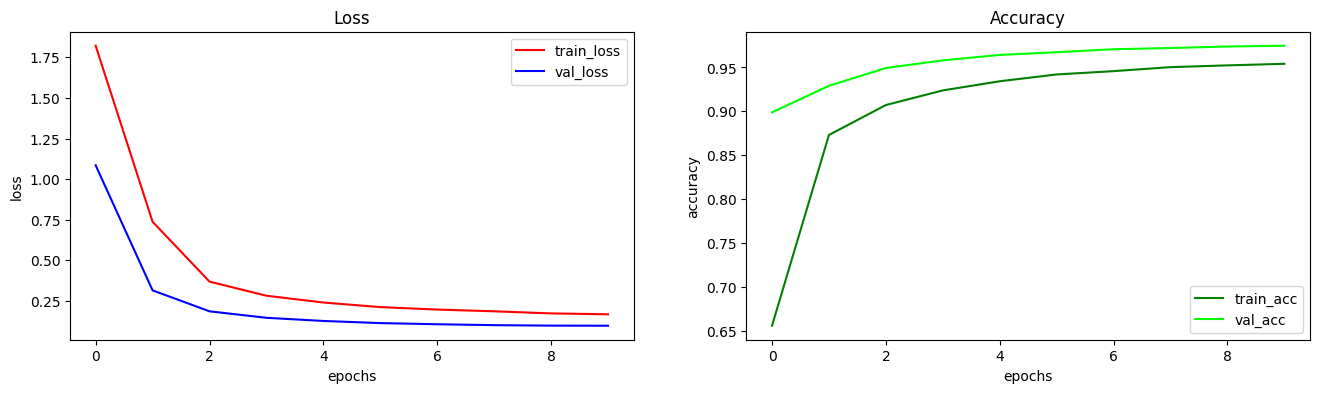


Epoch 010 train_loss: 0.1676     val_loss 0.0971 train_acc 0.9542 val_acc 0.9748


In [127]:
history = train_model(model, X_train, y_train, X_val, y_val, optimizer, criterion=criterion, n_epochs=n_epochs)


In [128]:
def predict(model: Module, X_test: Iterable, y_test):
    model.evaluate()
    predictions = []
    batches = get_batches(X_test, y_test)
    for inputs, labels in batches:
        outputs = model.forward(inputs)
        preds = np.argmax(outputs, 1)
        predictions += list(preds)
    return predictions

In [129]:
y_test_decoded = ohe.inverse_transform(y_test).ravel()
preds = predict(model, X_test, y_test)

In [130]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_decoded, preds)

0.9733

Print here your accuracy on test set. It should be around 90%.

In [131]:
accuracy_score(y_test_decoded, preds)

0.9733

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [40]:
import torch
from torch import nn
import torch.optim as optim

In [161]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(NUMBER_OF_FEATURES, 256),
            nn.BatchNorm1d(256),
            nn.LayerNorm(256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, n_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, input_data):
        return self.net.forward(input_data)

In [162]:
from torchsummary import summary

In [163]:
model = Network().to(device='cpu')

In [164]:
summary(model, (784, ), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
       BatchNorm1d-2                  [-1, 256]             512
         LayerNorm-3                  [-1, 256]             512
         LeakyReLU-4                  [-1, 256]               0
           Dropout-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
       BatchNorm1d-7                  [-1, 128]             256
         LayerNorm-8                  [-1, 128]             256
         LeakyReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
       LogSoftmax-12                   [-1, 10]               0
Total params: 236,682
Trainable params: 236,682
Non-trainable params: 0
-------------------------------

In [165]:
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, betas=[0.5, 0.5], eps=1e-5)

In [166]:
def fit_epoch(model, tepoch, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tepoch:
        inputs = torch.tensor(inputs)
        labels = torch.tensor(labels)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.argmax(axis=1))
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.shape[0]
        running_corrects += np.sum(preds.numpy() == ohe.inverse_transform(labels).ravel())
        processed_data += inputs.shape[0]
        tepoch.set_postfix(loss=loss.item(),
                accuracy=str(100. * running_corrects / processed_data)[:4])
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = torch.tensor(inputs)
        labels = torch.tensor(labels)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.argmax(axis=1))
        preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.shape[0]
        running_corrects += np.sum(preds.numpy() == ohe.inverse_transform(labels).ravel())
        processed_size += inputs.shape[0]
    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size
    return val_loss, val_acc

In [167]:
def train_model(model: Module, X_train: Iterable, 
                y_train: Iterable, X_val: Iterable,
                y_val: Iterable, optimizer: Callable,
                criterion: Criterion, batch_size:int = 128,
                show: bool=True, n_epochs: int=20, log_time: bool=True
                ):
                
    history = []
    times = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    start_time = time.time() if log_time else None
    for epoch in range(n_epochs):
        batches = get_batches(X_train, y_train, train=True, batch_size=batch_size)

        # train step
        model.train()
        with tqdm(batches, unit="batch", total=len(X_train) // batch_size) as tepoch:
            tepoch.set_description("Epoch {} / {}".format(epoch + 1, n_epochs))
            train_loss, train_acc = fit_epoch(model, tepoch, criterion, optimizer)

        # validation step
        val_batches = get_batches(X_val, y_val, batch_size)
        model.eval()
        val_loss, val_acc = eval_epoch(model, val_batches, criterion)
        history.append((train_loss, train_acc, val_loss, val_acc))
        if start_time:
            times.append(time.time() - start_time)
        if show:
            display.clear_output(wait=True)
            plot_epoch(history)
        tepoch.update(1)
        tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                        v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    if log_time:
        return history, times
    return history

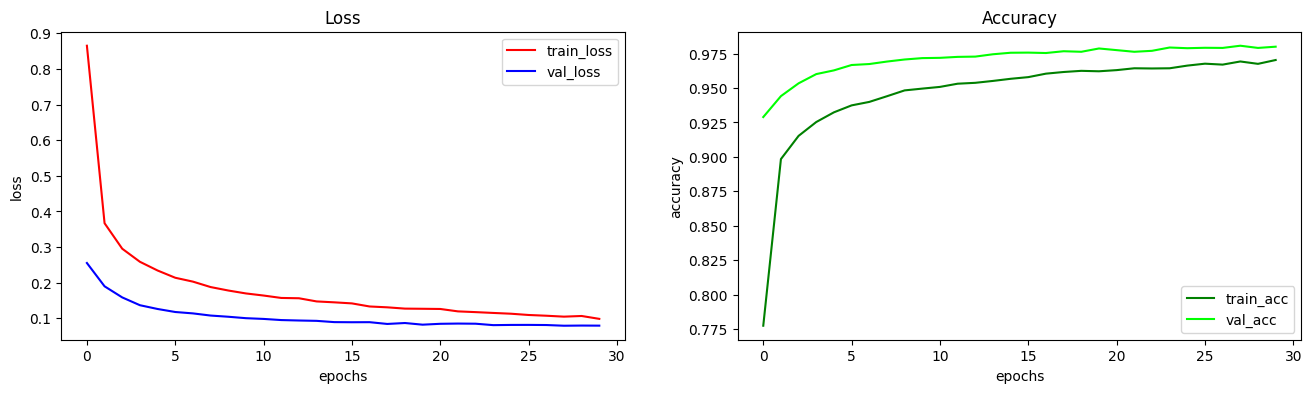


Epoch 030 train_loss: 0.0986     val_loss 0.0796 train_acc 0.9703 val_acc 0.9800


In [168]:
history_torch = train_model(model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs=30, batch_size=256)

In [169]:
def predict(model: nn.Module, X_test: Iterable, y_test):
    model.eval()
    predictions = []
    batches = get_batches(X_test, y_test)
    for inputs, labels in batches:
        inputs = torch.tensor(inputs)
        labels = torch.tensor(labels)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1).numpy()
        predictions += list(preds)
    return predictions

In [172]:
y_test_decoded = ohe.inverse_transform(y_test).ravel()
preds = predict(model, X_test, y_test)

In [173]:
accuracy_score(y_test_decoded, preds)

0.9782

It is absolutely incomparable in terms of time, and it is an obvious inference. But it is quite similar in terms of quality, and it is intriguing one. 